In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from Hybrid.neuralnet import construct_climdev_model, ClimLogProbLayer, preferred_loss, earlystop

In [288]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [290]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'linear') # sigmoid not the same as softmax (latter sums to 1)
])

2021-08-06 08:27:00.739150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-06 08:27:00.739175: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-06 08:27:00.739211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104.knmi.nl): /proc/driver/nvidia/version does not exist
2021-08-06 08:27:00.739431: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


So to summarize:
* sigmoid produces per output [0,1] by 1/(1 + exp(-x_i))
* softmax produces [0,1] over the whole vector exp(x_i)/sum(exp(x))
They advise not to use softmax as activation somehow. Back propagation of loss is apparently better on the raw x. But cross entropy loss would still need to know they are coding for probabilities, so SparseCategoricalCrossentropy(from_logits=True). Basically because cross entropy again takes log(p). Basically uses integer labels to index.
sccn is better on memory with many classes, because one-hot does not need to be in memory.

In [71]:
model.set_weights(wght)

In [7]:
model.output_shape

(None, 10)

In [8]:
predictions = model(x_train[:1]).numpy()

In [9]:
predictions

array([[ 0.12503259,  1.0469252 , -0.21665932,  0.39617884, -0.23199446,
         0.00365373, -0.15059008,  0.6000847 ,  0.83890784,  0.04767439]],
      dtype=float32)

In [12]:
tf.nn.softmax(predictions).numpy()

array([[0.08028147, 0.20183115, 0.05704537, 0.10528649, 0.05617724,
        0.07110517, 0.06094161, 0.12910047, 0.16392583, 0.07430518]],
      dtype=float32)

In [40]:
model.layers[-1].activation

<function tensorflow.python.keras.activations.linear(x)>

In [49]:
wght = model.get_weights()

In [72]:
test = model(x_train[:1]).numpy()

In [102]:
test

array([[-0.11352906,  0.34729177,  1.0644339 ,  0.5578108 ,  0.4750592 ,
         0.40783092, -0.34774545,  0.01247715, -0.29448655, -0.04110484]],
      dtype=float32)

In [64]:
wght[0][0][0]

-0.003932774

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [18]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 712us/step - loss: 0.2606 - accuracy: 0.9243
Epoch 2/5
1875/1875 [==============================] - 1s 719us/step - loss: 0.1141 - accuracy: 0.9656
Epoch 3/5
1875/1875 [==============================] - 1s 708us/step - loss: 0.0780 - accuracy: 0.9768
Epoch 4/5
1875/1875 [==============================] - 1s 712us/step - loss: 0.0591 - accuracy: 0.9818
Epoch 5/5
1875/1875 [==============================] - 1s 712us/step - loss: 0.0461 - accuracy: 0.9861


In [20]:
model(x_test[:1,:,:])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ -4.7125406 ,  -8.343181  ,  -0.87435186,   0.7036193 ,
        -10.174395  ,  -7.2959085 , -11.953187  ,  11.537861  ,
         -4.317952  ,  -2.3435347 ]], dtype=float32)>

In [19]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0727 - accuracy: 0.9759


[0.07271945476531982, 0.9758999943733215]

In [21]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [22]:
probability_model(x_test[:1,:,:])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[8.7605208e-08, 2.3214652e-09, 4.0684954e-06, 1.9712319e-05,
        3.7194303e-10, 6.6158750e-09, 6.2799640e-11, 9.9997509e-01,
        1.2998615e-07, 9.3621543e-07]], dtype=float32)>

In [128]:
probability_model.layers[0].layers[-1].weights

[<tf.Variable 'dense_13/kernel:0' shape=(128, 10) dtype=float32, numpy=
 array([[-0.05601987, -0.16742739,  0.18540995, ...,  0.4315883 ,
         -0.5043025 , -0.5293284 ],
        [-0.10358016,  0.27437437,  0.3868654 , ...,  0.00583949,
          0.37827742, -0.5964153 ],
        [ 0.3542829 , -0.43914926,  0.07479873, ...,  0.07123072,
          0.23323284, -0.15051797],
        ...,
        [-0.5266266 , -0.04204959, -0.7249568 , ...,  0.2896955 ,
         -0.1330448 ,  0.08046518],
        [-0.1475971 ,  0.1735117 ,  0.12642029, ...,  0.29665697,
         -0.30806977, -0.05913567],
        [ 0.12246256, -0.22739708,  0.12419337, ..., -0.1415676 ,
          0.22693579,  0.1645778 ]], dtype=float32)>,
 <tf.Variable 'dense_13/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.08749525, -0.06465504,  0.01288976, -0.07438051,  0.02712399,
         0.07164072, -0.00017467, -0.05728686,  0.12236173, -0.02882186],
       dtype=float32)>]

In [120]:
probability_model.layers[0].summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [78]:
class ConstantProbLayer(tf.keras.layers.Layer):
  def __init__(self, as_logit = False, activation = 'linear', **kwargs):
    super(ConstantProbLayer, self).__init__(**kwargs)
    self.as_logit = as_logit
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    self.nout = int(input_shape[-1])
    # Uniform dist. summing to 1
    if self.as_logit:
        self.constantval = np.log(1/self.nout)
    else:
        self.constantval = 1/self.nout
    self.probs = self.add_weight(name = "climprob",
                                 shape=[self.nout,],
                                 initializer = tf.keras.initializers.Constant(self.constantval),
                                 trainable = False
                                )

  def call(self, inputs):
    return self.activation(tf.add(inputs, self.probs))

layer = ConstantProbLayer(True, activation = 'relu')
layer(tf.zeros((10,5)))

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [173]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'linear'),
    ConstantProbLayer(as_logit = True, activation = 'softmax')
])

In [174]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1290      
_________________________________________________________________
constant_prob_layer_8 (Const (None, 10)                10        
Total params: 101,780
Trainable params: 101,770
Non-trainable params: 10
_________________________________________________________________


In [175]:
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [176]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 715us/step - loss: 0.2666 - accuracy: 0.9241
Epoch 2/5
1875/1875 [==============================] - 1s 715us/step - loss: 0.1157 - accuracy: 0.9656
Epoch 3/5
1875/1875 [==============================] - 1s 718us/step - loss: 0.0802 - accuracy: 0.9761
Epoch 4/5
1875/1875 [==============================] - 1s 712us/step - loss: 0.0603 - accuracy: 0.9815
Epoch 5/5
1875/1875 [==============================] - 1s 718us/step - loss: 0.0474 - accuracy: 0.9853


### With some real data
So we need a layer generating the probabilities based on changing time = log(p_clim_t). And a layer to add: z = log(p_clim) + x. When this is softmax activated it becomes a multiplication: exp(z) = exp(log(p_clim))\*exp(x) = exp(x)\*p_clim

x can be understood as the logarithm of the multiplier.

In [58]:
daythreshold = 2
leadtime = 2 # How to pool lead-times? Perhaps just forecast-observation pairs from multiple. And at inference time you can even predict a single one.
clustid = 9

In [59]:
# Output data. shape (nsamples, nclasses)
datapath = '/nobackup_1/users/straaten/match/paper3-2_tg-ex-q0.75-7D_JJA_45r1_1D_15-t2m-q095-adapted-mean_0ff8862e17c44052ae517a5c35817e6b.h5'
df = pd.read_hdf(datapath)
obs = df.loc[df['clustid'] == clustid, ['time','observation']].set_index('time')
obs = obs.loc[~obs.index.duplicated(keep = 'first'),[('observation',0)]] >= daythreshold

In [60]:
# Input data
z300_input = '/nobackup_1/users/straaten/match/paper3-3-simple_z-anom_JJA_45r1_7D-roll-mean_1-swvl-simple-mean_faed7e53f7784d378ebdbe7dad8bef90.h5'
swvl13_input = '/nobackup_1/users/straaten/match/paper3-3-simple_swvl13-anom_JJA_45r1_7D-roll-mean_1-swvl-simple-mean_6921d7dbb71344da826d7647596273df.h5'
z300 = pd.read_hdf(z300_input) # only 1 clustid
z300 = z300.loc[z300['leadtime'] == leadtime,['time','forecast']].set_index('time')
swvl13 = pd.read_hdf(swvl13_input) # only 1 clustid
swvl13 = swvl13.loc[swvl13['leadtime'] == leadtime,['time','forecast']].set_index('time')

inputs = pd.DataFrame({'time':z300.index.to_julian_date().values,'z300-anom':z300.mean(axis=1),'swvl13-anom':swvl13.mean(axis = 1)}) # simply make ensemble means
# match the indices.
common_dates = inputs.index.intersection(obs.index)
inputs = inputs.loc[common_dates,:]
scaler = MinMaxScaler()
X = scaler.fit_transform(inputs)

In [61]:
obs = obs.loc[common_dates,:]
y = obs.values

In [62]:
lr = LogisticRegression()
lr.fit(X = X[:,[0]], y = y.ravel())

LogisticRegression()

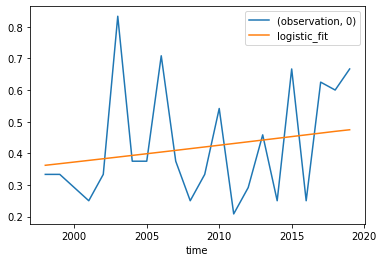

In [63]:
ax = obs.groupby(obs.index.year).mean().plot()
problog = pd.Series(lr.predict_proba(X[:,[0]])[:,-1], index = common_dates)
problog.groupby(problog.index.year).mean().plot(ax = ax, label = 'logistic_fit')
plt.legend()
plt.show()

In [64]:
neg_pos_coef = np.concatenate((-lr.coef_[0,[0]],lr.coef_[0,[0]])) # first negative class, then positive class. such that output index zero corresponds to observed zero (important for sparse loss)
neg_pos_intercept = np.concatenate((-lr.intercept_,lr.intercept_)) 
climprobkwargs=dict(coefs = neg_pos_coef, intercepts= neg_pos_intercept, activation = 'linear')
model = construct_climdev_model(n_classes = 2, n_hidden_layers= 0, n_features = 2, climprobkwargs=climprobkwargs)

In [65]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
clim_log_prob_layer_6 (ClimLogP (None, 2)            4           input_15[0][0]                   
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            6           input_16[0][0]                   
____________________________________________________________________________________________

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=preferred_loss, #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']) # Don't pay too much attention to the accuracy. 
model.fit([X[:,1:],X[:,:1]], y + 0.0, epochs=20, validation_split=0.2, callbacks=[earlystop])  # TODO proper validation data.

Epoch 1/20
13/13 [==============================] - 0s 7ms/step - loss: 0.6449 - accuracy: 0.6139 - val_loss: 0.6679 - val_accuracy: 0.6238
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6395 - accuracy: 0.6139 - val_loss: 0.6618 - val_accuracy: 0.6634
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6342 - accuracy: 0.6139 - val_loss: 0.6569 - val_accuracy: 0.6535
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6292 - accuracy: 0.6163 - val_loss: 0.6512 - val_accuracy: 0.6832
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6243 - accuracy: 0.6188 - val_loss: 0.6462 - val_accuracy: 0.6832
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6190 - accuracy: 0.6262 - val_loss: 0.6412 - val_accuracy: 0.6931
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.6436 - val_loss: 0.6340 - val_accuracy: 0.7327
Epoch 8/20
13/13 [==

In [57]:
model.weights

[<tf.Variable 'clim_log_prob_layer_5/a:0' shape=(1, 2) dtype=float32, numpy=array([[-0.5244906,  0.5244906]], dtype=float32)>,
 <tf.Variable 'clim_log_prob_layer_5/b:0' shape=(2,) dtype=float32, numpy=array([ 0.50696945, -0.50696945], dtype=float32)>,
 <tf.Variable 'dense_6/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.00354854, -0.00354813],
        [ 0.00603458, -0.00603973]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.00490489, -0.00491104], dtype=float32)>]

In [32]:
model.weights

[<tf.Variable 'clim_log_prob_layer_2/a:0' shape=(1, 2) dtype=float32, numpy=array([[-0.44177666,  0.44177666]], dtype=float32)>,
 <tf.Variable 'clim_log_prob_layer_2/b:0' shape=(2,) dtype=float32, numpy=array([ 0.49933448, -0.49933448], dtype=float32)>,
 <tf.Variable 'dense_3/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.23659346,  0.24781771],
        [ 0.16843504, -0.15094835]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.04692203, -0.0185008 ], dtype=float32)>]

In [33]:
from sklearn.metrics import brier_score_loss

In [68]:
brier_score_loss(y.squeeze(),model.predict([X[:,1:],X[:,:1]])[:,-1])

0.18951317975506135

In [69]:
brier_score_loss(y.squeeze(),lr.predict_proba(X[:,:1])[:,-1])

0.24163914317645918

In [40]:
model.predict([X[:,1:],X[:,:1]])

array([[0.65654016, 0.34345993],
       [0.6966039 , 0.3033961 ],
       [0.66736686, 0.33263314],
       ...,
       [0.47216058, 0.5278394 ],
       [0.48224783, 0.51775223],
       [0.48790988, 0.5120901 ]], dtype=float32)

In [28]:
lr.predict_proba(X[:,:1])

array([[0.62230292, 0.37769708],
       [0.62224879, 0.37775121],
       [0.62220819, 0.37779181],
       ...,
       [0.51448616, 0.48551384],
       [0.51444302, 0.48555698],
       [0.51438549, 0.48561451]])

I was very confused about an old combinations of the model: Binary prediction with 1 output node (logarithm of probability of the positive class), using BinaryCrossEntropyLoss with from_logits = True. It was non-symmetric and led to completely wrong training.

Good things:
* untrained model (no extra activation) predicts exactly the same log_p_clim for the positive class as lr.predict_log_proba
* I could use softmax activation inside the model (stores logits under the hood as output.\_keras_logits, which are directed, under the hood, by tf.keras.backend.sparse_categorical_crossentropy to tf.nn.sparse_softmax_cross_entropy_with_logits, even when choosing from_logits = False)
* If predicting two classes even for the binary case, then I should supply two sets of logistic regression coefficients. Luckily the negative values of postive class coefficients should give the negative class logodds. (both of which will sum to 1). So I can arrange that outside the neural network.

Incomprehensible things:
* probabilistic predictions outside range [0-1]. Actually because the binary cross-entropy loss from_logits can be lowered by issueing logits > 0, leading to probabilities larger than 1.
* also the binary cross-entropy from logits is not symmetrical whereas the one from probabilities is. I very much require it to be symmetrical.
* The reason was the difference between logits and logarithms. Logit is the inverse of the sigmoid function. I am outputting a (multitplied) logarithm of a probability. This is also why sigmoid activation would fail to produce the right results

In [219]:
print(logitloss(np.array([0]), np.log(np.array([0.1]))))
print(logitloss(np.array([1]), np.log(np.array([0.9]))))
print(logitloss(np.array([0]), np.log(np.array([0.1])/(1-np.array([0.1])))))
print(logitloss(np.array([1]), np.log(np.array([0.9])/(1-np.array([0.9]))))) # Now things are symmetric.
print(probloss(np.array([0]), np.array([0.1]))) # 
print(probloss(np.array([1]), np.array([0.9])))

tf.Tensor(0.09531018137931824, shape=(), dtype=float64)
tf.Tensor(0.7472143769264221, shape=(), dtype=float64)
tf.Tensor(0.10536051541566849, shape=(), dtype=float64)
tf.Tensor(0.10536051541566849, shape=(), dtype=float64)
tf.Tensor(0.10536040365695953, shape=(), dtype=float64)
tf.Tensor(0.10536040365695953, shape=(), dtype=float64)
